In [145]:
from google.colab import drive
import os
import sys

drive.mount('/content/drive')

PROJECT_PATH = '/content/drive/MyDrive/SVGEditor'
CODE_PATH = f"{PROJECT_PATH}/code"
MODEL_PATH = f"{PROJECT_PATH}/models"
RESOURCE_PATH = f"{PROJECT_PATH}/Resource"

if CODE_PATH not in sys.path:
    sys.path.insert(0, CODE_PATH)

# Single target processing
TARGET_NAME = "153_B"
ORIGINAL_PATH = f"{RESOURCE_PATH}/{TARGET_NAME}/Original"
INTERMEDIATE_FILES_PATH = f"{RESOURCE_PATH}/{TARGET_NAME}/IntermediateFiles"
COMPARISON_PATH = f"{RESOURCE_PATH}/{TARGET_NAME}/Comparison"
RESULT_PATH = f"{RESOURCE_PATH}/{TARGET_NAME}/Result"

# Input image file
INPUT_IMAGE = f"{ORIGINAL_PATH}/153_B.jpg"

# Vectorization input - the edited image from Qwen
VECTORIZATION_INPUT = f"{INTERMEDIATE_FILES_PATH}/153_B_qwen_edit.png"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [146]:
# Install dependencies (removed duplicates)
%pip install diffusers accelerate safetensors transformers huggingface_hub segment-anything opencv-python pillow matplotlib scikit-image scikit-learn cairosvg moviepy shapely networkx lxml

# Install vectorization dependencies
%pip install skan rdp

import shutil
import subprocess

# 1. Clean existing code directory and clone fresh repository
if os.path.exists(CODE_PATH):
    shutil.rmtree(CODE_PATH)

os.chdir(PROJECT_PATH)
result = subprocess.run(['git', 'clone', 'https://github.com/huanbasara/SVGEditor.git', 'code'],
                       capture_output=True, text=True)
print(f"Code repository {'successfully' if result.returncode == 0 else 'failed'} cloned")

# 2. Display latest commit information
os.chdir(CODE_PATH)
commit_info = subprocess.run(['git', 'log', '-1', '--pretty=format:%h|%ci|%s'],
                           capture_output=True, text=True)

if commit_info.returncode == 0:
    hash_code, commit_time, commit_msg = commit_info.stdout.strip().split('|', 2)
    print(f"Latest commit: {hash_code} ({commit_time.split()[0]}) - {commit_msg}")

# 3. Add code path to Python sys.path
if CODE_PATH not in sys.path:
    sys.path.insert(0, CODE_PATH)
    print(f"Added {CODE_PATH} to Python path")

# 4. Clear custom modules from cache
modules_to_clear = ['sam_processor', 'svglib', 'utils']

for base in modules_to_clear:
    to_remove = [m for m in sys.modules if m.startswith(base)]
    for m in to_remove:
        del sys.modules[m]

print("Modules reloaded!")

Code repository successfully cloned
Latest commit: 230779c (2025-09-30) - 修复SVGPath.from_str闭合bug: 只在add_closing=True时才添加回到起点的线
Modules reloaded!


  skeleton_clean = remove_small_objects(skeleton_binary, min_size=3)

  plt.tight_layout()

  plt.tight_layout()

  plt.tight_layout()

  plt.tight_layout()

  plt.tight_layout()

  plt.tight_layout()



🔍 调试信息:
  原始骨架像素数: 12245
  清理后骨架像素数: 12245
  丢失像素数: 0
  检测到的连通区域数: 40


  fig.canvas.print_figure(bytes_io, **kw)

  fig.canvas.print_figure(bytes_io, **kw)

  fig.canvas.print_figure(bytes_io, **kw)

  fig.canvas.print_figure(bytes_io, **kw)

  fig.canvas.print_figure(bytes_io, **kw)

  fig.canvas.print_figure(bytes_io, **kw)



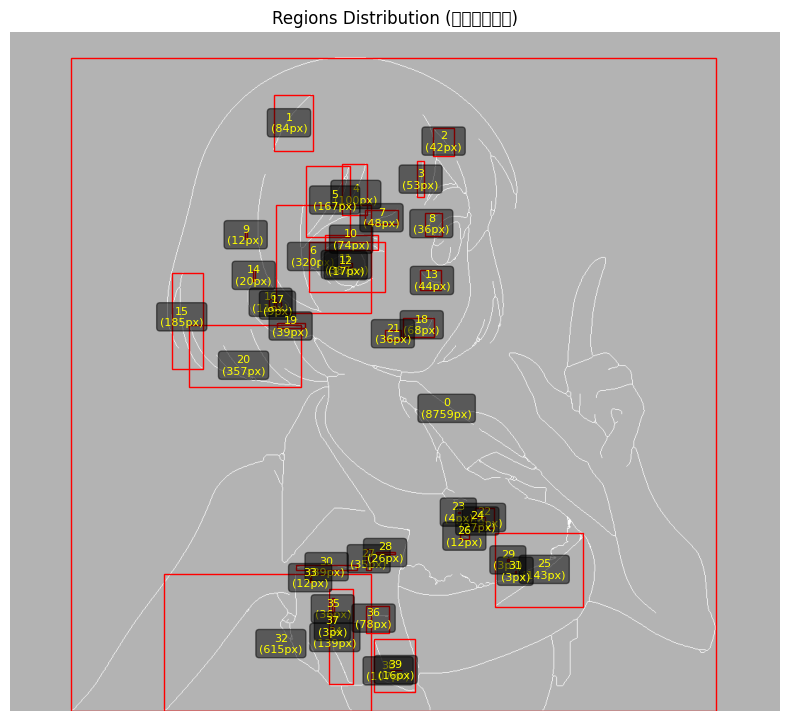

  ⬆️ 查看上图，找到左眼对应的region编号
  Region 0: 8759 像素 -> 处理中... 完成，循环231次，处理8759/8759像素(100.0%)
  Region 1: 84 像素 -> 处理中... 完成，循环3次，处理84/84像素(100.0%)
  Region 2: 42 像素 -> 处理中... 完成，循环2次，处理42/42像素(100.0%)
  Region 3: 53 像素 -> 处理中... 完成，循环4次，处理53/53像素(100.0%)
  Region 4: 100 像素 -> 处理中... 完成，循环2次，处理100/100像素(100.0%)
  Region 5: 167 像素 -> 处理中... 完成，循环3次，处理167/167像素(100.0%)
  Region 6: 320 像素 -> 处理中... 完成，循环8次，处理320/320像素(100.0%)
  Region 7: 48 像素 -> 处理中... 完成，循环1次，处理48/48像素(100.0%)
  Region 8: 36 像素 -> 处理中... 完成，循环1次，处理36/36像素(100.0%)
  Region 9: 12 像素 -> 处理中... 完成，循环1次，处理12/12像素(100.0%)
  Region 10: 74 像素 -> 处理中... 完成，循环1次，处理74/74像素(100.0%)
  Region 11: 387 像素 -> 处理中... 完成，循环22次，处理387/387像素(100.0%)
  Region 12: 17 像素 -> 处理中... 完成，循环1次，处理17/17像素(100.0%)
  Region 13: 44 像素 -> 处理中... 完成，循环2次，处理44/44像素(100.0%)
  Region 14: 20 像素 -> 处理中... 完成，循环2次，处理20/20像素(100.0%)
  Region 15: 185 像素 -> 处理中... 完成，循环2次，处理185/185像素(100.0%)
  Region 16: 11 像素 -> 处理中... 完成，循环1次，处理11/11像素(100.0%)
  Region 17: 9 像素 -> 处理中.

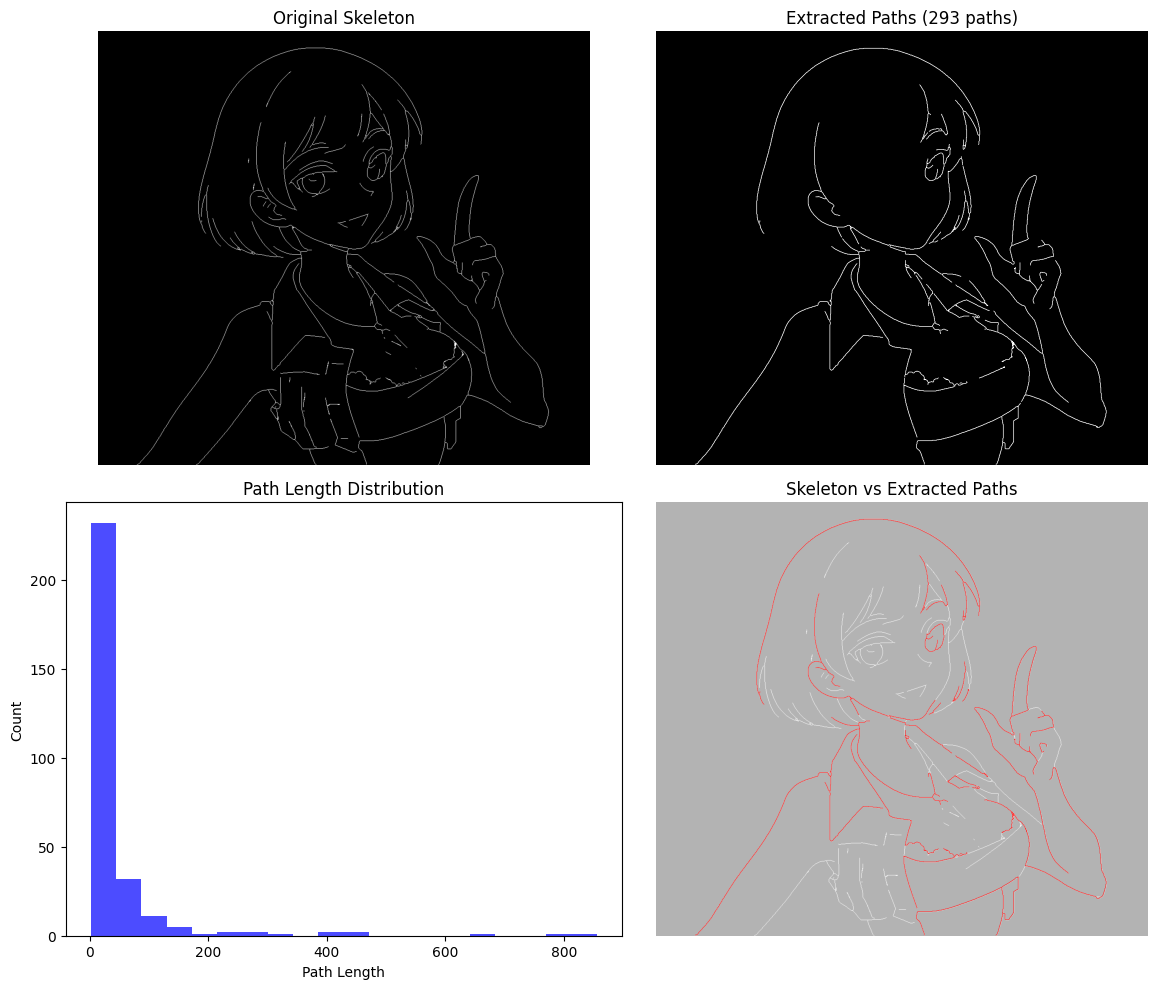

In [147]:
# ==================== 骨架到SVG转换（精简版+可视化） ====================

import skan
import matplotlib.pyplot as plt
from svglib.svg import SVG
from svglib.svg_path import SVGPath
from svglib.svg_primitive import SVGPathGroup
from svglib.geom import Bbox

def extract_open_paths(skeleton):
    """从骨架提取开放路径"""
    from skimage.measure import label, regionprops
    from skimage.morphology import remove_small_objects

    skeleton_binary = (skeleton > 0).astype(np.uint8)

    # 调试信息：检查remove_small_objects的影响
    skeleton_clean = remove_small_objects(skeleton_binary, min_size=3)
    print(f"🔍 调试信息:")
    print(f"  原始骨架像素数: {np.sum(skeleton_binary)}")
    print(f"  清理后骨架像素数: {np.sum(skeleton_clean)}")
    print(f"  丢失像素数: {np.sum(skeleton_binary) - np.sum(skeleton_clean)}")

    # 尝试直接用原始骨架（注释掉skeleton_clean，改用skeleton_binary）
    labeled = label(skeleton_binary)  # 改用skeleton_binary替代skeleton_clean
    regions = regionprops(labeled)
    print(f"  检测到的连通区域数: {len(regions)}")

    # 可视化每个region的位置
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(skeleton_binary, cmap='gray', alpha=0.3)

    # 为每个region标注序号和边界框
    for i, region in enumerate(regions):
        y, x = region.centroid
        bbox = region.bbox  # (min_row, min_col, max_row, max_col)

        # 画边界框
        from matplotlib.patches import Rectangle
        rect = Rectangle((bbox[1], bbox[0]), bbox[3]-bbox[1], bbox[2]-bbox[0],
                         fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)

        # 标注序号和像素数
        ax.text(x, y, f'{i}\n({len(region.coords)}px)',
               color='yellow', fontsize=8, ha='center', va='center',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.5))

    ax.set_title('Regions Distribution (骨架区域分布)')
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    print(f"  ⬆️ 查看上图，找到左眼对应的region编号")

    paths = []
    processed_regions = 0
    skipped_regions = 0

    for i, region in enumerate(regions):
        coords = region.coords
        print(f"  Region {i}: {len(coords)} 像素", end="")

        if len(coords) < 2:
            print(" -> 跳过（太小）")
            skipped_regions += 1
            continue

        processed_regions += 1
        print(f" -> 处理中...", end="")

        # 计算每个点的邻居数量
        def count_neighbors(point, all_coords):
            cnt = 0
            for c in all_coords:
                if (abs(c[0] - point[0]) <= 1 and abs(c[1] - point[1]) <= 1 and tuple(c) != tuple(point)):
                    cnt += 1
            return cnt

        endpoints = [p for p in coords if count_neighbors(p, coords) == 1]
        remaining = set(tuple(c) for c in coords)

        initial_remaining = len(remaining)
        loop_count = 0

        while remaining:
            loop_count += 1
            start = None
            if endpoints:
                for ep in endpoints:
                    if tuple(ep) in remaining:
                        start = ep
                        break
            if start is None:
                start = next(iter(remaining))

            path_coords = []
            cur = start
            path_coords.append((int(cur[1]), int(cur[0])))
            remaining.remove(tuple(cur))

            while remaining:
                nxt = None
                for c in list(remaining):
                    if (abs(c[0] - cur[0]) <= 1 and abs(c[1] - cur[1]) <= 1):
                        nxt = c
                        break
                if nxt is None:
                    break
                path_coords.append((int(nxt[1]), int(nxt[0])))
                remaining.remove(nxt)
                cur = nxt

            if len(path_coords) >= 2:
                paths.append(path_coords)

        # 检查是否有遗漏的像素
        pixels_processed = initial_remaining - len(remaining)
        coverage = (pixels_processed / initial_remaining * 100) if initial_remaining > 0 else 0

        result_msg = f" 完成，循环{loop_count}次，处理{pixels_processed}/{initial_remaining}像素({coverage:.1f}%)"
        if len(remaining) > 0:
            result_msg += f" ⚠️ 遗漏{len(remaining)}像素"
        print(result_msg)

    print(f"\n📊 统计:")
    print(f"  处理的区域: {processed_regions}/{len(regions)}")
    print(f"  跳过的区域: {skipped_regions}")
    print(f"  总路径数: {len(paths)}")

    # 调试：检查paths的结构
    if paths:
        print(f"\n🔍 路径结构调试:")
        print(f"  第1条路径类型: {type(paths[0])}")
        print(f"  第1条路径长度: {len(paths[0])}")
        print(f"  第1条路径前3个点: {paths[0][:3] if len(paths[0]) >= 3 else paths[0]}")

    return paths

def build_svg_paths(paths):
    """将路径转换为SVG路径对象"""
    svg_paths = []
    for path in paths:
        d = f"M {path[0][0]:.2f} {path[0][1]:.2f}"
        for x, y in path[1:]:
            d += f" L {x:.2f} {y:.2f}"
        # 注意：SVGPath.from_str() 返回的是 SVGPathGroup，需要提取其中的 SVGPath
        path_group = SVGPath.from_str(d, add_closing=False)
        # 从 SVGPathGroup 中提取真正的 SVGPath 对象
        svg_paths.extend(path_group.svg_paths)  # 使用 extend 而不是 append
    return svg_paths

def visualize_results(skeleton, paths):
    """可视化结果"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # 原始骨架
    axes[0, 0].imshow(skeleton, cmap='gray')
    axes[0, 0].set_title('Original Skeleton')
    axes[0, 0].axis('off')

    # 提取的路径
    axes[0, 1].imshow(np.zeros_like(skeleton), cmap='gray')
    for path in paths[:100]:  # 只显示前100条路径
        path_array = np.array(path)
        axes[0, 1].plot(path_array[:, 0], path_array[:, 1], 'w-', linewidth=0.5)
    axes[0, 1].set_title(f'Extracted Paths ({len(paths)} paths)')
    axes[0, 1].axis('off')

    # 路径长度分布
    path_lengths = [len(path) for path in paths]
    axes[1, 0].hist(path_lengths, bins=20, alpha=0.7, color='blue')
    axes[1, 0].set_title('Path Length Distribution')
    axes[1, 0].set_xlabel('Path Length')
    axes[1, 0].set_ylabel('Count')

    # 对比图
    axes[1, 1].imshow(skeleton, cmap='gray', alpha=0.3)
    for path in paths[:50]:  # 只显示前50条路径
        path_array = np.array(path)
        axes[1, 1].plot(path_array[:, 0], path_array[:, 1], 'r-', linewidth=0.5, alpha=0.7)
    axes[1, 1].set_title('Skeleton vs Extracted Paths')
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

# 主流程
skeleton_path = os.path.join(INTERMEDIATE_FILES_PATH, f"{TARGET_NAME}_skeleton.png")
if os.path.exists(skeleton_path):
    skeleton = cv2.imread(skeleton_path, cv2.IMREAD_GRAYSCALE) > 0
    paths = extract_open_paths(skeleton)

    if paths:
        print(f"\n🔍 SVG生成调试:")
        print(f"  输入paths数量: {len(paths)}")

        svg_paths = build_svg_paths(paths)
        print(f"  生成svg_paths数量: {len(svg_paths)}")

        viewbox = Bbox(0, 0, skeleton.shape[1], skeleton.shape[0])
        group = SVGPathGroup(svg_paths, fill=False, stroke_width=2.0)
        print(f"  SVGPathGroup中的路径数: {len(group.svg_paths)}")

        # 确保路径有filling属性
        for sp in group.svg_paths:
            if not hasattr(sp, 'filling'):
                sp.filling = 0

        svg = SVG([group], viewbox=viewbox)
        print(f"  SVG对象中的总路径数: {len(list(svg.paths))}")

        raw_svg_path = os.path.join(INTERMEDIATE_FILES_PATH, f"{TARGET_NAME}_raw.svg")
        svg.save_svg(raw_svg_path, coordinate_precision=1)

        print(f"✅ SVG保存: {raw_svg_path}")
        print(f"✅ 提取了 {len(paths)} 条路径")

        # 可视化结果
        visualize_results(skeleton, paths)
    else:
        print("❌ 路径提取失败")
else:
    print("❌ 骨架图片不存在")

🧪 测试 SVGPathGroup.to_str() 方法

📍 方法1：使用 SVGPath.from_str() （返回的是SVGPathGroup）
  - SVGPath.from_str() 返回类型: SVGPathGroup
  - 包含的 svg_paths 数量: 1
  - 第一个 svg_path 类型: SVGPath

📍 方法2：手动创建 SVGPath 对象
  - 手动创建的对象类型: SVGPath
  - to_str() 返回: M0 0 M100 100 L200 200

✅ 创建了 3 个真正的 SVGPath 对象

✅ 创建了 SVGPathGroup，包含 3 个路径
  - group.svg_paths[0] 的类型: SVGPath

📝 生成的 SVG 字符串：
--------------------------------------------------------------------------------
<path id="" fill="none" stroke="#000000" stroke-width="2.0" stroke-opacity="1.0" stroke-linecap="round" stroke-linejoin="round"  filling="0" d="M0.0 0.0 M100.0 100.0 L200.0 200.0"></path> <path id="" fill="none" stroke="#000000" stroke-width="2.0" stroke-opacity="1.0" stroke-linecap="round" stroke-linejoin="round"  filling="1" d="M0.0 0.0 M300.0 300.0 L400.0 400.0"></path> <path id="" fill="none" stroke="#000000" stroke-width="2.0" stroke-opacity="1.0" stroke-linecap="round" stroke-linejoin="round"  filling="2" d="M0.0 0.0 M500.0 500.0 L600.0 600.0

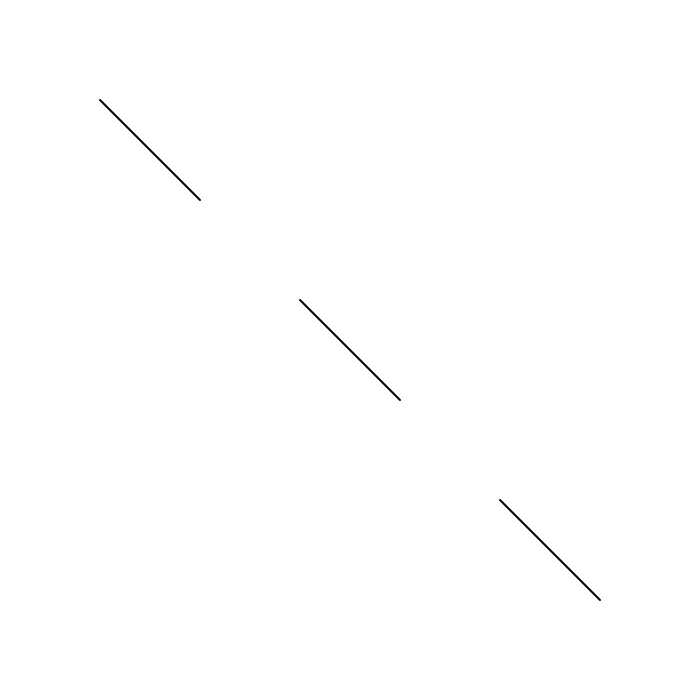

✅ SVG 渲染成功


In [ ]:
# ==================== 测试 SVGPathGroup.to_str() 逻辑 ====================

print("🧪 测试 SVGPathGroup.to_str() 方法\n")

# 1. 创建几个简单的测试路径（注意：SVGPath.from_str 返回的是 SVGPathGroup！）
from svglib.svg_path import SVGPath
from svglib.svg_primitive import SVGPathGroup
from svglib.svg_command import SVGCommandMove, SVGCommandLine
from svglib.geom import Point

# 方法1：直接用SVGPath.from_str().svg_paths[0] 获取真正的SVGPath
print("📍 方法1：使用 SVGPath.from_str() （返回的是SVGPathGroup）")
path_group_1 = SVGPath.from_str("M 100 100 L 200 200", add_closing=False)
print(f"  - SVGPath.from_str() 返回类型: {type(path_group_1).__name__}")
print(f"  - 包含的 svg_paths 数量: {len(path_group_1.svg_paths)}")
print(f"  - 第一个 svg_path 类型: {type(path_group_1.svg_paths[0]).__name__}\n")

# 方法2：手动创建真正的 SVGPath 对象
print("📍 方法2：手动创建 SVGPath 对象")
test_path = SVGPath()
test_path.path_commands = [
    SVGCommandMove(Point(100, 100)),
    SVGCommandLine(Point(100, 100), Point(200, 200))
]
test_path.filling = 0
print(f"  - 手动创建的对象类型: {type(test_path).__name__}")
print(f"  - to_str() 返回: {test_path.to_str()}\n")

# 使用方法2创建3个真正的SVGPath
test_paths = []
coords = [(100, 100, 200, 200), (300, 300, 400, 400), (500, 500, 600, 600)]
for i, (x1, y1, x2, y2) in enumerate(coords):
    p = SVGPath()
    p.path_commands = [
        SVGCommandMove(Point(x1, y1)),
        SVGCommandLine(Point(x1, y1), Point(x2, y2))
    ]
    p.filling = i
    test_paths.append(p)

print(f"✅ 创建了 {len(test_paths)} 个真正的 SVGPath 对象\n")

# 2. 创建 SVGPathGroup
group = SVGPathGroup(test_paths, fill=False, stroke_width=2.0)
print(f"✅ 创建了 SVGPathGroup，包含 {len(group.svg_paths)} 个路径")
print(f"  - group.svg_paths[0] 的类型: {type(group.svg_paths[0]).__name__}\n")

# 3. 调用 to_str() 方法
svg_str = group.to_str(coordinate_precision=1)

print("📝 生成的 SVG 字符串：")
print("-" * 80)
print(svg_str)
print("-" * 80)

# 4. 分析结果
print("\n🔍 结果分析：")
path_count = svg_str.count('<path')
print(f"  - 包含的 <path> 标签数量: {path_count}")

# 检查是否有嵌套的 <path> 标签
has_nested = False
d_attrs = svg_str.split('d="')
for i, d_attr in enumerate(d_attrs[1:], 1):
    d_value = d_attr.split('"')[0]
    if '<path' in d_value:
        has_nested = True
        print(f"  - ⚠️ 警告：在第 {i} 个 d 属性中检测到嵌套的 <path> 标签！")
        break

if not has_nested:
    print(f"  - ✅ 没有嵌套的 <path> 标签")

# 显示每个d属性
print(f"  - d 属性数量: {len(d_attrs) - 1}")
for i, d_attr in enumerate(d_attrs[1:], 1):
    d_value = d_attr.split('"')[0]
    print(f"  - Path {i} 的 d 属性: {d_value}")

# 5. 完整性测试：创建完整的SVG并可视化
from svglib.svg import SVG
from svglib.geom import Bbox

viewbox = Bbox(0, 0, 700, 700)
svg = SVG([group], viewbox=viewbox)
full_svg_str = svg.to_str(coordinate_precision=1)

print(f"\n📄 完整的 SVG 结构（前500字符）：")
print("-" * 80)
print(full_svg_str[:500])
print("-" * 80)

# 6. 显示SVG
from IPython.display import SVG as DisplaySVG, display
print("\n🖼️ SVG 可视化：")
try:
    display(DisplaySVG(full_svg_str))
    print("✅ SVG 渲染成功")
except Exception as e:
    print(f"❌ SVG 渲染失败: {e}")


In [ ]:
# ==================== 调试：检查路径闭合问题 ====================

print("🔍 检查生成的SVG路径是否有问题\n")

# 1. 检查前10条路径的数据
print("前10条路径的详细信息：")
print("="*80)
for i, svg_path in enumerate(svg_paths[:10]):
    path_str = svg_path.to_str()

    # 提取起点和终点坐标
    commands = path_str.split()
    start_point = f"{commands[1]} {commands[2]}" if len(commands) > 2 else "?"

    # 找最后一个L命令的坐标
    last_l_idx = -1
    for j in range(len(commands)-1, -1, -1):
        if commands[j] == 'L':
            last_l_idx = j
            break
    end_point = f"{commands[last_l_idx+1]} {commands[last_l_idx+2]}" if last_l_idx > 0 and last_l_idx+2 < len(commands) else "?"

    # 检查是否有闭合命令
    has_z = 'Z' in path_str or 'z' in path_str

    # 显示路径长度
    path_length = len(commands) // 3  # 大约的点数

    print(f"Path {i+1}:")
    print(f"  起点: M {start_point}, 终点: L {end_point}")
    print(f"  路径长度: 约{path_length}个点")
    print(f"  是否闭合: {'是 ⚠️' if has_z else '否 ✅'}")

    if len(path_str) > 150:
        print(f"  数据: {path_str[:70]}...{path_str[-70:]}")
    else:
        print(f"  数据: {path_str}")
    print()

# 2. 检查是否有异常长的线段
print("\n" + "="*80)
print("检查是否有异常长的线段（可能是错误连接）：\n")

abnormal_paths = []
for i, path in enumerate(paths[:100]):  # 检查前100条原始路径
    for j in range(len(path) - 1):
        x1, y1 = path[j]
        x2, y2 = path[j+1]
        distance = ((x2-x1)**2 + (y2-y1)**2)**0.5

        # 如果两个相邻点的距离超过100像素，可能有问题
        if distance > 100:
            abnormal_paths.append({
                'path_idx': i,
                'segment': j,
                'from': (x1, y1),
                'to': (x2, y2),
                'distance': distance
            })

if abnormal_paths:
    print(f"⚠️ 发现 {len(abnormal_paths)} 个异常长的线段：\n")
    for item in abnormal_paths[:5]:  # 只显示前5个
        print(f"  Path {item['path_idx']}, 线段 {item['segment']}: "
              f"({item['from'][0]}, {item['from'][1]}) -> ({item['to'][0]}, {item['to'][1]}) "
              f"距离: {item['distance']:.1f} 像素")
else:
    print("✅ 没有发现异常长的线段")

print(f"\n总结：")
print(f"  总路径数: {len(svg_paths)}")
print(f"  有闭合命令的路径数: {sum(1 for p in svg_paths if 'Z' in p.to_str() or 'z' in p.to_str())}")
print(f"  异常长线段数: {len(abnormal_paths)}")


🔍 检查生成的SVG路径是否有问题

前10条路径的详细信息：
Path 1:
  起点: M 118 L584, 终点: L ?
  路径长度: 约86个点
  是否闭合: 否 ✅
  数据: M583 118 L584 119 L585 120 L585 121 L586 122 L587 123 L587 124 L588 12...591 237 L592 236 L592 235 L593 234 L594 233 L594 232 L593 231 L583 118

Path 2:
  起点: M 152 L663, 终点: L ?
  路径长度: 约82个点
  是否闭合: 否 ✅
  数据: M662 152 L663 153 L664 154 L665 155 L666 156 L667 157 L667 158 L668 15...682 259 L683 258 L683 257 L683 256 L684 255 L684 254 L684 253 L662 152

Path 3:
  起点: M 183 L632, 终点: L ?
  路径长度: 约64个点
  是否闭合: 否 ✅
  数据: M631 183 L632 184 L632 185 L632 186 L633 187 L633 188 L634 189 L634 19...603 232 L602 233 L602 234 L601 235 L600 236 L599 237 L598 238 L631 183

Path 4:
  起点: M 202 L360, 终点: L ?
  路径长度: 约146个点
  是否闭合: 否 ✅
  数据: M360 202 L360 203 L359 204 L359 205 L359 206 L358 207 L358 208 L358 20...400 406 L401 406 L402 406 L403 407 L404 407 L405 407 L406 407 L360 202

Path 5:
  起点: M 240 L680, 终点: L ?
  路径长度: 约9个点
  是否闭合: 否 ✅
  数据: M680 240 L680 241 L680 242 L680 243 L680 244 L680 245 L680